# Verification

In [1]:
import glob
import os
import re
import unidecode
import random

import numpy as np
RND = 12345
random.seed(RND)
np.random.seed(RND)
from scipy.spatial.distance import cdist, pdist

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'Arial'

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

from tqdm import tqdm

### Preprocessing

We define a function to load the texts from under a given directory, as well as an aggressive cleaning function to reduce the OCR artifacts as much as possible:

In [2]:
DIRTY = re.compile(r'\s*\-\+')

def clean_text(text):
    """
    Fairly aggressive cleaning of a text to reduce
    normalization artifacts in the OCR
    """
    text = ' '.join(text.strip().split())
    text = text.replace('ſ', 's')
    text = re.sub(DIRTY, '', text)
    text = ''.join(c for c in text if c.isalpha() or c.isspace())
    text = ' '.join(text.split())
    text = unidecode.unidecode(text)
    return text

def load_folder(path=None, ext='.txt', size=None):
    """
    Load texts from a given directory, clean them
    and extract non-overlapping consecutive segments
    of a fixed size. Authors and titles are also
    extracted. Everything gets returned as a DataFrame.
    """
    texts = []
    for fn in tqdm(list(glob.glob(f'{path}/*{ext}'))):
        with open(fn, 'r') as f:
            text = f.read()
            text = clean_text(text)
            title = os.path.basename(fn).lower().replace(ext, '')
            meta = title.split('_')
            author, *title = meta
            title = author + ' ' + '_'.join(title)
            if size:
                cnt = 1
                si, ei = 0, size
                while ei < len(text):
                    texts.append([title + '_' + str(cnt), title, author, text[si:ei]])
                    si += size
                    ei += size
                    cnt += 1
            else:
                texts.append([title, title, author, text])
    
    texts = pd.DataFrame(texts, columns=('id', 'title', 'author', 'text'))
    texts = texts.set_index('id')
    return texts

We load the development or calibration data:

In [3]:
dev = load_folder('data/dev', size=None, ext='.txt')
dev = dev.sort_values(by='title')

100%|██████████| 35/35 [00:00<00:00, 331.97it/s]


We determine the mean size of a text in that material:

In [4]:
dev['length'] = dev.text.str.len()
SIZE = int(dev['length'].mean())
print('-> established sample size:', SIZE)

-> established sample size: 5454


Next, we also load the source data (by Goethe only) and the imposter data, but this time specifying the `size` parameter to segment the longer texts into consecutive chunks:

In [5]:
source = load_folder('data/source', ext='.txt', size=SIZE)
imposters = load_folder('data/imposters', ext='.txt', size=SIZE)

100%|██████████| 1774/1774 [03:14<00:00,  9.10it/s]


All these data are returned as Pandas `DataFrames` by `load_folder()`:

In [6]:
dev.head()

,title,author,text,length
id,,,,
goethe 01,goethe 01,goethe,Halle Leben und Charakter Herrn Christian Adol...,2391
goethe 02,goethe 02,goethe,Zurch Moralische Erzahlungen und Idyllen von D...,5851
goethe 03,goethe 03,goethe,Gedichte von einem polnischen Juden Mitau und ...,5683
goethe 04,goethe 04,goethe,Nachrede statt der versprochenen Vorrede Die b...,4260
goethe 05,goethe 05,goethe,Zurch Aussichten in die Ewigkeit in Briefen an...,7412


Note the imbalance between Goethe and the imposters in terms of number of chunks (which is a good thing):

In [7]:
print('# Goethe documents:', len(source))
print('# Imposter documents:', len(imposters))

# Goethe documents: 6372
# Imposter documents: 90531


### Vectorization

We are now ready to vectorize the data. We define the parameters for the token n-grams feature extraction and character n-gram extraction:

In [8]:
p_word = {'use_idf': True,
          'max_features': 50000,
          'analyzer': 'word',
          'min_df': 2,
          'lowercase': True,
          'norm': 'l1',
          'ngram_range': (1, 2)}
p_char = {'use_idf': True,
          'max_features': 50000,
          'analyzer': 'char',
          'min_df': 2,
          'lowercase': True,
          'norm': 'l1',
          'ngram_range': (3, 4)}

We use these settings to instantiate two TF-IDF vectorizers:

In [9]:
w_vectorizer = TfidfVectorizer(**p_word)
c_vectorizer = TfidfVectorizer(**p_char)

These vectorizers are then fitted on the source material by Goethe and the result of both vectorizers is concatentaed to form a single, long vector per document:

In [10]:
source_X = np.hstack((w_vectorizer.fit_transform(source['text']).toarray(),
                      c_vectorizer.fit_transform(source['text']).toarray()))

The fitted vectorizers then are used to transform the imposter data and the calibration data:

In [11]:
imposters_X = np.hstack((w_vectorizer.transform(imposters['text']).toarray(),
                         c_vectorizer.transform(imposters['text']).toarray()))

dev_X = np.hstack((w_vectorizer.transform(dev['text']).toarray(),
                   c_vectorizer.transform(dev['text']).toarray()))

These operations give us 3 dense matrices with a dimensionality of 100,000 throughout (i.e. 2 x 50,000):

In [12]:
print(source_X.shape)
print(imposters_X.shape)
print(dev_X.shape)

(6372, 100000)
(90531, 100000)
(35, 100000)


Finally, we binarize the author labels in the development data: $1$ for "Goethe" and $0$ for "not-Goethe":

In [13]:
dev_y = np.array([1 if a == 'goethe' else 0 for a in dev['author']])

### Calibration

We define a `Verifier` class that is the main workhorse of our verification approach:

In [14]:
class Verifier():
    def __init__(self, iters=100, 
                 rnd_prop=.5, random_state=1066,
                 num_instances=30, metric='cosine',
                 rnd_state=1234):
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.iters = iters
        self.rnd_prop = rnd_prop
        self.num_instances = num_instances
    
    def predict_proba(self, target, source_X, imposter_X):
        """
        target = (single) anonymous text
        source_X = candidate author
        imposter_X = imposter documents
        """
        total_features = imposter_X.shape[1]
        total_imposters = imposter_X.shape[0]
        total_source = source_X.shape[0]
        target = np.array([target])
        hits = np.zeros(self.iters)
            
        for it in range(self.iters):
            imposters_ = imposter_X[np.random.choice(total_imposters, self.num_instances, replace=False), :]
            source_ = source_X[np.random.choice(total_source, self.num_instances, replace=False), :]
            
            if self.rnd_prop < 1.0:
                idxs = np.random.choice(total_features, int(total_features * self.rnd_prop), replace=False)
                imposters_ = imposters_[:, idxs]
                source_ = source_[:, idxs]
                target_ = target[:, idxs]
            
            min_imp_dist = np.min(cdist(target_, imposters_, metric='cosine'))
            min_src_dist = np.min(cdist(target_, source_, metric='cosine'))
            
            if min_src_dist < min_imp_dist:
                hits[it] = 1
        
        return np.mean(hits)

We instantiate this verifier as follows:

In [15]:
verifier = Verifier(iters=500, num_instances=25)

Next, we apply the verifier to the calibration material and record the verification scores for each of the individual documents:

In [16]:
dev_probas = [verifier.predict_proba(target=t, source_X=source_X,
              imposter_X=imposters_X) for t in tqdm(dev_X)]

100%|██████████| 35/35 [24:48<00:00, 42.52s/it]


We can use the resulting probability array to calculate the precision, recall and F1 scores at various verification thresholds:

In [17]:
scores = []
for th in np.linspace(0, 1.001, 1000):
    labels_ = (dev_probas >= th) * 1
    scores.append((th,
                   f1_score(dev_y, labels_),
                   precision_score(dev_y, labels_),
                   recall_score(dev_y, labels_)))
thresholds, f1s, precisions, recalls = zip(*scores)

/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The maximal F1-score (in fact: perfect verification results) is reached for the following threshold:

In [18]:
max_idx = np.array(f1s).argmax()
max_f1 = f1s[max_idx]
max_th = thresholds[max_idx]
print(f'Dev results -> F1={max_f1} at th={max_th}')

Dev results -> F1=1.0 at th=0.5981951951951952


We can plot these results to inspect the trade-off between precision and recall across the spectrum of thresholds:

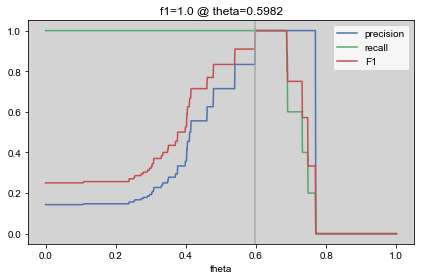

In [19]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='F1')
plt.axvline(max_th, ls='-', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.gca().set_facecolor('lightgrey')
plt.title(f'f1={round(max_f1, 4)} @ theta={round(max_th, 4)}')
plt.tight_layout()
plt.savefig('figures/dev_precrec.pdf')

Finally, let us plot the verification scores for the individual texts in the calibration set:

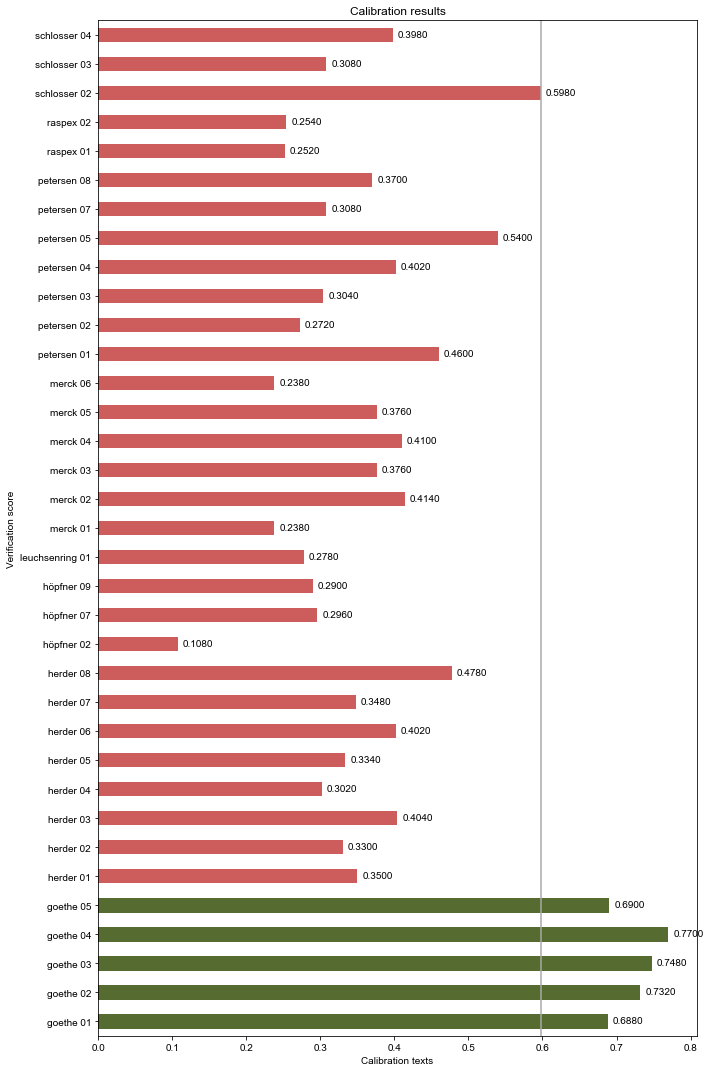

In [20]:
dev['proba'] = dev_probas
colors = ['darkolivegreen' if 'goethe' in c else 'indianred' for c in dev['title']]
ax = dev['proba'].plot('barh', figsize=(10, 15), color=colors)
for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(5, 5), textcoords='offset points')
ax.axvline(max_th, ls='-', c='darkgrey')
plt.xlabel('Calibration texts')
plt.ylabel('Verification score')
plt.title('Calibration results')
plt.tight_layout()
plt.savefig('figures/dev_bars.pdf')

### Application

We can now apply the verification system to the two test texts (long texts and short texts). Using a horizontal line, we again show the verification threshold that we obtained from the calibration phase:

In [21]:
for test_dir in 'test_long test_short'.split():
    test = load_folder(f'data/{test_dir}', ext='.txt', size=None)
    test = test.sort_values(by='title')
    test_X = np.hstack((w_vectorizer.transform(test['text']).toarray(),
                        c_vectorizer.transform(test['text']).toarray()))
    test_probas = [verifier.predict_proba(target=t, source_X=source_X,
                   imposter_X=imposters_X) for t in tqdm(test_X)]
    test['proba'] = test_probas
    colors = ['darkolivegreen' if 'goethe' in c else 'indianred' for c in test['title']]
    ax = test['proba'].plot('barh', figsize=(10, 15), color=colors)
    for p in ax.patches:
        ax.annotate('%.4f' % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                    xytext=(5, 5), textcoords='offset points')
    ax.axvline(max_th, ls='-', c='darkgrey')
    plt.xlabel('Test texts')
    plt.ylabel('Verification score')
    plt.title('Test results')
    plt.tight_layout()
    plt.savefig(f'figures/{test_dir}_bars.pdf')
    plt.clf();

100%|██████████| 16/16 [10:27<00:00, 39.21s/it]


<Figure size 720x1080 with 0 Axes>

That's all.

----------------------